In [23]:
# we are using tf serving to deploy bert model into production

In [24]:
# Classify spam vs no spam emails

In [25]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [26]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [28]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [29]:
747/4825
#15% spam emails, 85% ham emails: This indicates class imbalance.

0.15481865284974095

In [30]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [31]:
df_spam

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [32]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [33]:
df_spam.shape[0]

747

In [34]:
# class imbalance handled using under-sampling
# undersampling majority class 747 class.
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [35]:
# combining majority (undersampled) and minority class
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [36]:
df_balanced['Category'].value_counts()
# both our classes have count of 747, hence they are balanced.

Category
ham     747
spam    747
Name: count, dtype: int64

In [37]:
# convert 	'Category' column to numbers
#create a new column 'spam' by applying if x is spam return 1 else return 0 as data points.
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4879,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,1
3585,spam,Hi 07734396839 IBH Customer Loyalty Offer: The...,1
841,ham,I luv u soo much u dont understand how specia...,0
401,spam,FREE RINGTONE text FIRST to 87131 for a poly o...,1
840,spam,Last chance 2 claim ur £150 worth of discount ...,1


In [38]:
# Split it into training and test data set

In [39]:
# we are only interested in 2 columns 'Message' and 'spam'
X = df_balanced['Message']
y = df_balanced['spam']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_balanced['spam'])

In [40]:
X_train.head(4)

4430    Hey they r not watching movie tonight so i'll ...
5567    This is the 2nd time we have tried 2 contact u...
305     SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...
2224    Thanks for your ringtone order, ref number K71...
Name: Message, dtype: object

In [41]:
# Now lets import BERT model and get embeding vectors for few sample statements

In [42]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [43]:
# returns entire sentence embedding.
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences) # passing sentence to preprocess
    return bert_encoder(preprocessed_text)['pooled_output'] # pass preproccessed text to encoder ,return entire sentence word embeddings using 'pooled_output'.

#calling func, by passing sentence.
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351695, -0.5132727 , -0.88845736, ..., -0.74748874,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446677, ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [44]:
#Get embeding vectors for few sample words. Compare them using cosine similarity

In [45]:
# passing few words to get embedding.
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [46]:
# cosine similarity is between 0 and 1, 1 being the most similar and 0 being the most similar.
# (if two vectors to pointing to same direction, cosine similarity is 1)
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]]) # comparing banana and grapes.

array([[0.9911088]], dtype=float32)

In [47]:
'''
Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits
'''

'\nValues near to 1 means they are similar. 0 means they are very different.\nAbove you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits\n'

In [48]:
cosine_similarity([e[0]],[e[3]]) # Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

array([[0.8470387]], dtype=float32)

In [49]:
cosine_similarity([e[3]],[e[4]]) # Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

array([[0.98720354]], dtype=float32)

In [50]:
# Build Model

In [51]:
# There are two types of models you can build in tensorflow. 

#(1) Sequential
#(2) Functional

In [52]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')# let the model derive the shape.
preprocessed_text = bert_preprocess(text_input) # preprocessing
outputs = bert_encoder(preprocessed_text) # creating encoding using preproccessed data.

# Neural network layers
# need to pass previous output to current layers
h1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # using 0.1% dropout layer, also ge me entire word embeddings in a sentence using outputs['pooled_output']. 

# passing previous output h1 to h2 layer.
h2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(h1) # output layer with 1 neuron.

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [h2])

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [54]:
len(X_train)

1120

In [55]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [56]:
# Train the model

In [57]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 205s 5s/step - loss: 0.6753 - accuracy: 0.5714 - precision: 0.5749 - recall: 0.5482
Epoch 2/10
35/35 [==============================] - 182s 5s/step - loss: 0.5359 - accuracy: 0.7795 - precision: 0.7595 - recall: 0.8179
Epoch 3/10
35/35 [==============================] - 180s 5s/step - loss: 0.4613 - accuracy: 0.8455 - precision: 0.8462 - recall: 0.8446
Epoch 4/10
35/35 [==============================] - 178s 5s/step - loss: 0.4152 - accuracy: 0.8687 - precision: 0.8447 - recall: 0.9036
Epoch 5/10
35/35 [==============================] - 180s 5s/step - loss: 0.3806 - accuracy: 0.8795 - precision: 0.8709 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 185s 5s/step - loss: 0.3548 - accuracy: 0.8893 - precision: 0.8798 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 182s 5s/step - loss: 0.3263 - accuracy: 0.8929 - precision: 0.8806 - recall: 0.9089
Epoch 8/10
35/35 [==============================

In [58]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 66s 5s/step - loss: 0.2806 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144


[0.2805795669555664,
 0.9144384860992432,
 0.9144384860992432,
 0.9144384860992432]

In [59]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 61s 5s/step


In [60]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[171,  16],
       [ 16, 171]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

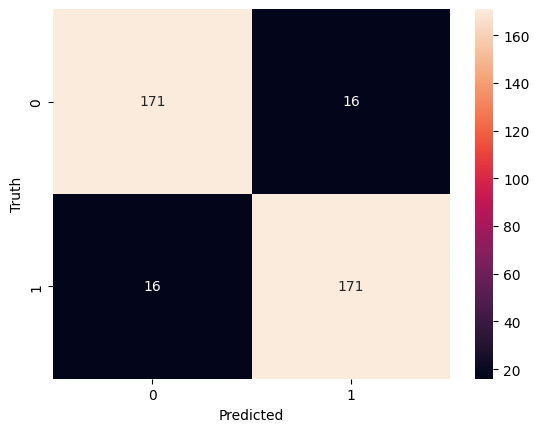

In [62]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [63]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       187
           1       0.91      0.91      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [64]:
# Inference

In [65]:
# just passing a sample to check
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.72528225],
       [0.784743  ],
       [0.72584236],
       [0.18681368],
       [0.10270076]], dtype=float32)

In [66]:
#saving version 1 of model
model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [67]:
#saving version 2 of model
model.save("saved_models/2/")

INFO:tensorflow:Assets written to: saved_models/2/assets


INFO:tensorflow:Assets written to: saved_models/2/assets


In [68]:
#saving version 3 of model
model.save("saved_models/3/")

INFO:tensorflow:Assets written to: saved_models/3/assets


INFO:tensorflow:Assets written to: saved_models/3/assets
